# Tree of Thoughts (ToT)

- Author: [Sunworl Kim](https://github.com/sunworl)
- Design:
- Peer Review:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb)

## Overview

Tree of Thoughts (ToT) is a systematic problem-solving framework that enhances language models' reasoning capabilities by exploring and maintaining multiple paths of thought simultaneously. 

The core concept of ToT breaks down problem-solving processes into multiple stages, where various "thoughts" are generated and evaluated at each stage, similar to how a chess player thinks several moves ahead. 

Each thought represents an independent solution path that the system explores and evaluates in parallel.


In this tutorial, we run a "Make 15" game that combines four numbers to reach 15 using an LLM agent search algorithm with Tree of Thoughts (ToT).

**Main steps**

1. Expand: Creative generation phase using LLM to explore all possible equation combinations

2. Score: Validation phase that evaluates how accurately generated equations reach the target value of 15

3. Prune: Optimization phase that selects only the best candidates to determine the starting point for the next exploration

**Key Components** 

- Reverse-Polish Notation(RPN) Calculator for equation evaluation
- LangChain-based solver 
- State-based graph management

**[Note]** This code is substantially derived from the [LangGraph Tree of Thoughts (ToT) tutorial](https://github.com/langchain-ai/langgraph/blob/f239b39060096ab2c8bff0d6303781efee174a5c/docs/docs/tutorials/tot/tot.ipynb).


### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Mathematical Equation Exploration and Evaluation Framework](#mathematical-equation-exploration-and-evaluation-framework)
- [LLM Configuration for Game Solution Generation](#llm-configuration-for-game-solution-generation)
- [Game Solution Explorer](#game-solution-explorer)
- [Create Graph](#create-graph)
- [Run Graph](#run-graph)


### References

- [Tree of Thoughts: Deliberate Problem Solving with Large Language Models](https://doi.org/10.48550/arXiv.2305.10601)

----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.

**[Note]**
- The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials. 
- Check out the  [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [49]:
%%capture --no-stderr
%pip install -U langchain-opentutorial

In [50]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_openai",
        "langchain_core",
        "langgraph"
    ],
    verbose=False,
    upgrade=False,
)

You can set API keys in a `.env` file or set them manually.

[Note] If you’re not using the `.env` file, no worries! Just enter the keys directly in the cell below, and you’re good to go.

In [ ]:
from dotenv import load_dotenv
from langchain_opentutorial import set_env

# Attempt to load environment variables from a .env file; if unsuccessful, set them manually.
if not load_dotenv():
    set_env(
        {
            "OPENAI_API_KEY": "",
            "LANGCHAIN_API_KEY": "",
            "LANGCHAIN_TRACING_V2": "true",
            "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
            "LANGCHAIN_PROJECT": "Tree of Thoughts (ToT)",
        }
    )

Environment variables have been set successfully.


## Mathematical Equation Exploration and Evaluation Framework 


Define a class that uilizes `Pydantic` to calculate RPN formulas.

`Pydantic` is a library that simplifies data validation.

In [52]:
import operator
from typing import List, Union, Literal, NamedTuple, Optional
from pydantic import BaseModel, Field, field_validator

# Define the available operators and token type
OperatorType = Literal["+", "-", "*", "/"]  
TokenType = Union[float, OperatorType]


class Equation(BaseModel):
    tokens: List[TokenType] = Field(
        description="The stack of tokens and operators in reverse-polish notation(RPN). Example: [2, 3, '+', 5, '*'] would evaluate to (2 + 3) * 5"
    )

    @field_validator('tokens')
    def clean_tokens(cls, v):    
        return [float(t) if isinstance(t, (int, float)) else t.strip() for t in v]

    # Validate operators 
    def validate_tokens(cls, v): 
        cleaned_tokens = []
        for token in v:
            if isinstance(token, str):
                token = token.strip()
                if token not in {'+', '-', '*', '/'}:
                    raise ValueError(f"Invalid operator: {token}")
            cleaned_tokens.append(token)
        return cleaned_tokens
    
    def compute(self) -> float:
        """Calculate RPN formula"""        
        op_funcs = {
            "+": operator.add,
            "-": operator.sub,
            "*": operator.mul,
            "/": operator.truediv,
        }
        stack = []
        for token in self.tokens:
            if isinstance(token, float):
                stack.append(token)
            else:
                b, a = stack.pop(), stack.pop()
                stack.append(op_funcs[token](a, b))

        return stack[0]

Define a class to organize and store the process of solving mathematical problems, including the generated equations.

In [53]:
class GuessEquations(BaseModel):
  
    reasoning: str = Field(
        description="Detailed explanation of how the formula was created and the process"
    )
    equations: List[Equation] = Field(  
        description="List of generated equations"
    )

This signifies a candidate equation that requires evaluation.

In [54]:
class Candidate(NamedTuple):
    candidate: Equation              # Equation to be evaluate
    score: Optional[float] = None    # Evaluation score of equation
    feedback: Optional[str] = None   # Evaluation opinion

    # Representation of Output
    def __str__(self):
        try:
            computed = self.candidate.compute()
            return f"Equation({self.candidate.tokens}) = {computed:.2f} (Score: {self.score:.2f if self.score is not None else 'N/A'})" 
        except Exception as e:
            return f"Invalid equation: {self.candidate.tokens}; Error: {str(e)}"

class ScoredCandidate(Candidate):
    candidate: Equation
    score: float
    feedback: str        

This Defines the fucdamental structures that are responsible for managing and configuring the state of ToT.

In [55]:
from typing_extensions import Annotated, TypedDict
from langchain_core.runnables import RunnableConfig

def update_candidates(
    existing: Optional[list] = None,
    updates: Optional[Union[list, Literal["clear"]]] = None,
) -> List[str]:
    if existing is None:
        existing = []
    if updates is None:
        return existing
    if updates == "clear":
        return []
    # Concatenate the lists
    return existing + updates


class ToTState(TypedDict):
    
    problem: str
    candidates: Annotated[List[Candidate], update_candidates]
    scored_candidates: Annotated[List[ScoredCandidate], update_candidates]
    depth: Annotated[int, operator.add]

class Configuration(TypedDict, total=False):
    max_depth: int
    threshold: float
    k: int
    beam_size: int

def _ensure_configurable(config: RunnableConfig) -> Configuration:
    configurable = config.get("configurable", {})
    return {
        **configurable,
        "max_depth": configurable.get("max_depth", 10),
        "threshold": config.get("threshold", 1.0),      # success threshold
        "k": configurable.get("k", 5),                  # Number of candidates to generate
        "beam_size": configurable.get("beam_size", 3),  # Number of candidates to keep
    }

class ExpansionState(ToTState):
    seed: Optional[Candidate]

## LLM Configuration for Game Solution Generation

Construct a solution generation pipeline to automate the "Make 15" game using LangChain and OpenAI.

- ChatPromptTemplate : Generate system prompts that define the rules and objectives of the game.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# Define the Prompt Template
prompt = ChatPromptTemplate.from_messages(
    [
        ( # System prompt: Define the rules of the "Make 15" game
            "system",
            """You are playing Make 15. Create equations that evaluate to exactly 15 using the provided numbers.
            Rules:
            1. Use each number exactly once
            2. You can use +, -, *, / operators
            3. The result must be exactly 15
            4. Submit {k} different valid guesses        
            Evaluate your guesses carefully before submitting."""
        ),

        ( # User prompt: Includes the number to use and a history of previous attempts
            "user", 
            "Numbers to use: {problem}\nPrevious attempt (if any): {candidate}"
        ),
    ],
).partial(candidate="")
llm = ChatOpenAI(model="gpt-4o-mini")

bound_llm = llm.with_structured_output(GuessEquations)   # Output setting
solver = prompt | bound_llm   # Create pipeline

## Game Solution Explorer

Implement a sophisticated search algorithm to solve the "Make 15" game.

A function that calculates the score of a candidate equation, evaluating how far it has reached the target value of 15.

In [57]:
from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from typing import Dict, Any


def compute_score(problem: str, candidate: Candidate) -> ScoredCandidate:
    numbers = list(map(float, problem.split()))
    used_numbers = [
        token for token in candidate.candidate.tokens if isinstance(token, (int, float))
    ]
    # Check if every number is used exactly once
    if sorted(used_numbers) != sorted(numbers):
        return ScoredCandidate(
            candidate=candidate.candidate,
            score=0,
            feedback="The equation must use all 4 numbers exactly once."
        )
    # Score between 0 and 1 based on difference from 15    
    try:
        result = candidate.candidate.compute()
        score = max(0.0, 1.0 - abs(result - 15) / 15)
        feedback = f"Result: {result}"
    except Exception as e:
        return ScoredCandidate(
            candidate=candidate.candidate,
            score=0, 
            feedback=f"Invalid equation. Error: {repr(e)}"
        )
           
    return ScoredCandidate(
        candidate=candidate.candidate,
        score=score,
        feedback=feedback
    )

Core Algorithm Functions.

Calculate the scores for all generated candidate equations and select the candidate equations with the highest scores.

In [ ]:
# Create new candidates using LLM
def expand(state: ExpansionState, *, config: RunnableConfig) -> Dict[str, List[str]]:
   configurable = _ensure_configurable(config)

   # Ensure problem is a string
   problem = state["problem"]
   if isinstance(problem, list):
       problem = problem[0]

   try:
        equation_submission = solver.invoke(
            {
                "problem": problem,
                "candidate": str(state.get("seed", "")),
                "k": configurable["k"],
            },
            config=config,
        )
        return {
            "candidates": [
                Candidate(candidate=eq) 
                for eq in equation_submission.equations
                if all(t in {'+', '-', '*', '/'} or isinstance(t, (int, float)) 
                    for t in eq.tokens)
            ]
        }
   except Exception as e:
        return {"candidates": []}


# Calculate the score for each candidate equation
def score(state: ToTState) -> Dict[str, List[ScoredCandidate]]:
    candidates = state.get("candidates", [])
    if not isinstance(candidates, list):
        return {"scored_candidates": [], "candidates": "clear"}        
    scored = [
        compute_score(state["problem"], candidate) 
        for candidate in candidates 
        if hasattr(candidate, 'candidate')
    ]
    return {"scored_candidates": scored, "candidates": "clear"}


# Choose the candidates with the best results
# Keep only top candidates as big as beam_size
def prune(state: ToTState, *, config: RunnableConfig) -> Dict[str, List[Dict[str, Any]]]:
    scored_candidates = state["scored_candidates"]
    beam_size = _ensure_configurable(config)["beam_size"]
    organized = sorted(
        scored_candidates, 
        key=lambda x: x.score if isinstance(x, ScoredCandidate) else -float('inf'),
        reverse=True
    )
    pruned = organized[:beam_size]
    return {
        "candidates": pruned, # Update the starting point for the next iteration
        "scored_candidates": "clear", # Clear the old memory
        "depth": 1, # Increment the depth by 1
    }

Check if the correct answer has been found or if maximum depth has been reached to determine the next step.

In [59]:
def should_terminate(state: ToTState, config: RunnableConfig):
    configurable = _ensure_configurable(config)
    if not state["candidates"]:
        return "__end__"
    
    best_candidate = state["candidates"][0]
    solved = isinstance(best_candidate, ScoredCandidate) and abs(best_candidate.score - 1.0) < 1e-6
    
    if solved or state["depth"] >= configurable["max_depth"]:
        return "__end__"
    
    return [Send("expand", {**state, "seed": candidate}) for candidate in state["candidates"]]

## Create Graph

Construct a solution exploration graph for the "Make 15" game using LangGraph.

In [60]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Create the graph
def create_graph(config: Configuration = None) -> StateGraph:
    if config is None:
        config = {
            "max_depth": 10,
            "threshold": 1.0,
            "k": 5,
            "beam_size": 3
        }

    builder = StateGraph(state_schema=ToTState, config_schema=Configuration)

    # Add nodes : expand, score, prune
    builder.add_node(expand)
    builder.add_node(score)
    builder.add_node(prune)

    # Add edges : Define the execution order between nodes
    builder.add_edge("expand", "score")
    builder.add_edge("score", "prune")
    builder.add_conditional_edges("prune", should_terminate, path_map=["expand", "__end__"])

    # Set entry point
    builder.add_edge("__start__", "expand")

    return builder.compile(checkpointer=MemorySaver())

Visualize the compiled graph structure.

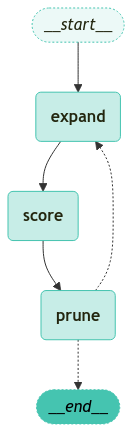

In [61]:
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(create_graph())

## Run Graph

Generate the number puzzles that fit a range using the Number Combination Puzzle Generator.

In [62]:
import itertools
import random

def generate_make_puzzles(count=10, seed=None):
    if seed is not None:
        random.seed(seed)
    
    numbers = list(range(1, 10))
    all_combinations = list(itertools.combinations(numbers, 4))
    selected_combinations = random.sample(all_combinations, min(count, len(all_combinations)))
    
    return [" ".join(map(str, combo)) for combo in selected_combinations]

# Example of generated number puzzles
puzzles = generate_make_puzzles()
print(f"Example puzzles: {puzzles[:3]}")

Example puzzles: ['3 4 6 9', '1 4 7 8', '1 2 5 8']


Find the equation to reach the number 15 by combining the numbers in the given puzzle.

In [63]:
config = {
    "configurable": {
        "thread_id": "make15_test",
        "max_depth": 10,
        "threshold": 1.0,
        "k": 5,
        "beam_size": 3
    },
    "recursion_limit": 50
}

# Graph initialization
graph = create_graph()

# Create a puzzle for testing
puzzle = generate_make_puzzles(1, seed=42)[0]
print(f"New puzzle: {puzzle}")

# Run in a stream manner and monitor each step
for step in graph.stream({"problem": puzzle}, config):
    print(f"Step: {step}")

New puzzle: 2 5 6 7
Step: {'expand': {'candidates': [Candidate(candidate=Equation(tokens=[6.0, 5.0, 2.0, 7.0, '*', '-', '+']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[7.0, 2.0, 5.0, '*', 6.0, '-']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[2.0, 7.0, '*', 5.0, '-', 6.0]), score=None, feedback=None), Candidate(candidate=Equation(tokens=[5.0, 6.0, 7.0, '-', 2.0, '*']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[6.0, 7.0, '+', 2.0, '*', '-']), score=None, feedback=None)]}}
Step: {'score': {'scored_candidates': [ScoredCandidate(candidate=Equation(tokens=[6.0, 5.0, 2.0, 7.0, '*', '-', '+']), score=0.0, feedback='Result: -3.0'), ScoredCandidate(candidate=Equation(tokens=[7.0, 2.0, 5.0, '*', 6.0, '-']), score=0.4666666666666667, feedback='Result: 7.0'), ScoredCandidate(candidate=Equation(tokens=[2.0, 7.0, '*', 5.0, '-', 6.0]), score=0.6, feedback='Result: 9.0'), ScoredCandidate(candidate=Equation(tokens=[5.0, 6.0, 7.0, '-',

Show the final results for the top three scores.

In [64]:
def print_results(graph: StateGraph, config: dict):
    # Get final status
    final_state = graph.get_state(config)
    # Extract candidate solutions
    candidates = final_state.values["candidates"]
 
    print("\nFinal Results:")
    print("-" * 50)
    for i, candidate in enumerate(candidates, 1):
        print(f"Solution {i}: {candidate}")
    print("-" * 50)

final_state = graph.get_state(config)
best_solution = final_state.values["candidates"][0]  # Extract the highest score answer
search_depth = final_state.values["depth"]  # Check search depth


print_results(graph, config)


Final Results:
--------------------------------------------------
Solution 1: [Equation(tokens=[6.0, 5.0, '+', 2.0, '*', 7.0, '-']), 1.0, 'Result: 15.0']
Solution 2: [Equation(tokens=[2.0, 7.0, '*', 5.0, '-', 6.0, '+']), 1.0, 'Result: 15.0']
Solution 3: [Equation(tokens=[6.0, 2.0, '*', 5.0, '-', 7.0, '+']), 0.9333333333333333, 'Result: 14.0']
--------------------------------------------------
